In [1]:
from ProbaData import *

from supreshelper import *

from SimpleCNN import SimpleCNN

import tensorflow as tf
import time

from IPython.display import clear_output

In [2]:
data_dir = "DataGenerated/"
ds = ProbaVDataset("DataGenerated/")

In [3]:
def _parse_function(example_proto):
    keys_to_features = {'all':tf.io.FixedLenFeature((384, 384*3), tf.float32)}
    parsed_features = tf.io.parse_single_example(example_proto, keys_to_features)
    return ds.load_train_image(parsed_features['all'])

### Define our datasets from TFrecords

In [4]:
batch_size = 8

train_dataset = tf.data.TFRecordDataset(glob(data_dir +  "train/*/*/all.tfrecords"))
train_dataset = train_dataset.shuffle(len(glob(data_dir +  "train/*/*/all.tfrecords")))
#train_dataset = train_dataset.repeat()  
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
train_dataset = train_dataset.batch(batch_size)

In [5]:
dev_dataset = tf.data.TFRecordDataset(glob(data_dir +  "dev/*/*/all.tfrecords"))
train_dataset = train_dataset.shuffle(len(glob(data_dir +  "dev/*/*/all.tfrecords")))
#dev_dataset = dev_dataset.repeat()  
dev_dataset = dev_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
dev_dataset = dev_dataset.batch(batch_size)

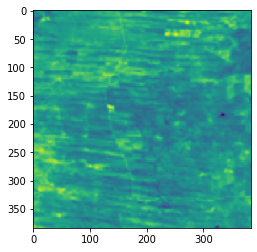

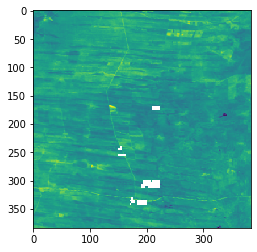

In [6]:
for a in train_dataset.take(1):
    plt.figure()
    plt.imshow(a[0][0][:,:,0])
    plt.figure()
    plt.imshow(a[1][0][:,:,0])

In [7]:
model = SimpleCNN()

In [8]:
import tensorflow.keras.backend as K

In [9]:
mse_loss = tf.keras.losses.MeanSquaredError()
mae_loss = tf.keras.losses.MeanAbsoluteError()

In [10]:
def applyMask(hr, generated):
    obs = tf.where(tf.math.is_nan(hr), False, True)
    clr = obs
    hr_ = tf.boolean_mask(hr, clr)
    generated_ = tf.boolean_mask(generated, clr)
    return hr_, generated_

In [11]:
def cMSE(hr_masked, generated_masked):

    # calculate the bias in brightness b
    pixel_diff = hr_masked - generated_masked
    b = K.mean(pixel_diff)

    # calculate the corrected clear mean-square error
    pixel_diff -= b
    cMse = K.mean(pixel_diff * pixel_diff)

    return cMse

In [12]:
def clearMSE(hr, generated):
    """As defined in https://kelvins.esa.int/proba-v-super-resolution/scoring/
    
        MSE loss that takes into account brightness and stuff TODO
    """
    quality_map = tf.where(tf.math.is_nan(hr), 0.0, 1.0)
    generated_ = tf.math.multiply(generated, quality_map)
    hr_ = tf.math.multiply(hr, quality_map)
    
    # calculate bias brightness
    bias = tf.math.reduce_mean(generated_ - hr_) 
    loss = tf.math.reduce_mean(tf.pow(hr_ - (generated_ - bias), 2))

    return loss

In [13]:
a = tf.random.uniform([384,384,1], dtype=tf.float32)
b = tf.random.uniform([384,384,1], dtype=tf.float32)
clearMSE(a,b)

<tf.Tensor: id=1148, shape=(), dtype=float32, numpy=0.16725129>

In [14]:
from tensorflow.keras.optimizers import Adam

In [15]:
EPOCHS = 5000
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
checkpoint_dir = './TrainingCheckpointSimple'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model.simpleCNN)

In [17]:
@tf.function
def compute_loss(lr, hr):
    output = model.simpleCNN(lr, training=True)
    hr_masked, output_masked = applyMask(hr, output) 
    return cMSE(hr_masked, output_masked) + mae_loss(hr_masked, output_masked)


In [18]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as model_tape:
        loss = compute_loss(lr, hr)
        # We compute gradient for each part
        model_gardients = model_tape.gradient(loss, model.simpleCNN.trainable_variables)
        # We apply the gradient to the variables, tf2.0 way
        optimizer.apply_gradients(zip(model_gardients, model.simpleCNN.trainable_variables))

In [19]:
def show_dev_pred(generator, lr, hr):
    predicted = generator.predict(lr)
    plt.figure(figsize=(15,15))
    
    display_list = [lr[0][:,:,0], predicted[0][:,:,0], hr[0][:,:,0]]
    title = ['Input Image', 'Predicted Image', 'Real image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    

In [20]:
losses_record = []

def train(train_dataset, dev_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        if (epoch + 1) % 20 == 0:
            for lr, hr in dev_dataset.take(1):
                print("Showing current result")
                show_dev_pred(model.simpleCNN, lr, hr)
            
        loss = 0
        for lr, hr in dev_dataset:
            loss += compute_loss(lr, hr)

        losses_record.append(loss)
        
        for lr, hr in train_dataset:
            train_step(lr, hr)
        
        # saving (checkpoint) the model every 100 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        if (epoch + 1) % 1 == 0:
            print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
            print('current val losses: ' + str(loss))
            print('=============================================')

W0711 10:55:40.423849 140433895077696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Time taken for epoch 1 is 108.09068846702576 sec

current val losses: tf.Tensor(1.8757625, shape=(), dtype=float32)
Time taken for epoch 2 is 99.639004945755 sec

current val losses: tf.Tensor(1.119345, shape=(), dtype=float32)
Time taken for epoch 3 is 99.94228029251099 sec

current val losses: tf.Tensor(0.2016746, shape=(), dtype=float32)
Time taken for epoch 4 is 99.78920364379883 sec

current val losses: tf.Tensor(0.11436382, shape=(), dtype=float32)
Time taken for epoch 5 is 100.35492539405823 sec

current val losses: tf.Tensor(0.09484069, shape=(), dtype=float32)
Time taken for epoch 6 is 99.83852028846741 sec

current val losses: tf.Tensor(0.09340024, shape=(), dtype=float32)
Time taken for epoch 7 is 99.9278028011322 sec

current val losses: tf.Tensor(0.09108536, shape=(), dtype=float32)
Time taken for epoch 8 is 100.23478102684021 sec

current val losses: tf.Tensor(0.092201896, shape=(), dtype=float32)
Time taken for epoch 9 is 99.8092794418335 sec

current val losses: tf.Tens

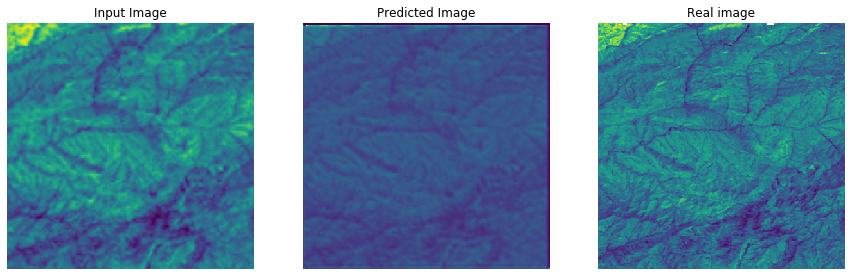

Time taken for epoch 20 is 98.48917746543884 sec

current val losses: tf.Tensor(0.055313233, shape=(), dtype=float32)
Time taken for epoch 21 is 97.21640229225159 sec

current val losses: tf.Tensor(0.05270547, shape=(), dtype=float32)
Time taken for epoch 22 is 97.31638956069946 sec

current val losses: tf.Tensor(0.0523471, shape=(), dtype=float32)
Time taken for epoch 23 is 97.31219410896301 sec

current val losses: tf.Tensor(0.053767122, shape=(), dtype=float32)
Time taken for epoch 24 is 97.30251741409302 sec

current val losses: tf.Tensor(0.0523792, shape=(), dtype=float32)
Time taken for epoch 25 is 97.6690559387207 sec

current val losses: tf.Tensor(0.047576934, shape=(), dtype=float32)
Time taken for epoch 26 is 97.17434811592102 sec

current val losses: tf.Tensor(0.046256393, shape=(), dtype=float32)
Time taken for epoch 27 is 97.46872568130493 sec

current val losses: tf.Tensor(0.041607272, shape=(), dtype=float32)
Time taken for epoch 28 is 99.1253252029419 sec

current val l

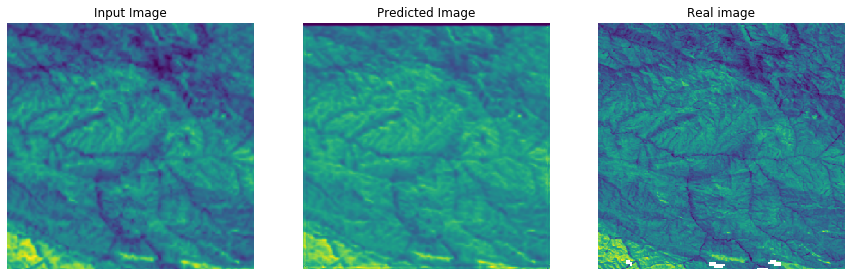

Time taken for epoch 40 is 100.7471764087677 sec

current val losses: tf.Tensor(0.033753477, shape=(), dtype=float32)
Time taken for epoch 41 is 100.62039995193481 sec

current val losses: tf.Tensor(0.036535695, shape=(), dtype=float32)
Time taken for epoch 42 is 99.82700896263123 sec

current val losses: tf.Tensor(0.035467315, shape=(), dtype=float32)
Time taken for epoch 43 is 100.16394257545471 sec

current val losses: tf.Tensor(0.034513727, shape=(), dtype=float32)
Time taken for epoch 44 is 100.19244813919067 sec

current val losses: tf.Tensor(0.03230214, shape=(), dtype=float32)
Time taken for epoch 45 is 99.32559943199158 sec

current val losses: tf.Tensor(0.032497514, shape=(), dtype=float32)
Time taken for epoch 46 is 100.97492837905884 sec

current val losses: tf.Tensor(0.039214812, shape=(), dtype=float32)
Time taken for epoch 47 is 100.86010646820068 sec

current val losses: tf.Tensor(0.03515981, shape=(), dtype=float32)
Time taken for epoch 48 is 92.93689942359924 sec

cur

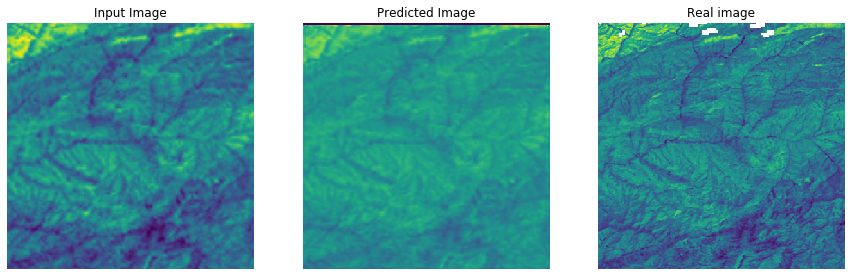

Time taken for epoch 60 is 96.69155859947205 sec

current val losses: tf.Tensor(0.02930069, shape=(), dtype=float32)
Time taken for epoch 61 is 92.60621666908264 sec

current val losses: tf.Tensor(0.03204958, shape=(), dtype=float32)
Time taken for epoch 62 is 95.01477265357971 sec

current val losses: tf.Tensor(0.03134489, shape=(), dtype=float32)
Time taken for epoch 63 is 95.62533569335938 sec

current val losses: tf.Tensor(0.030286051, shape=(), dtype=float32)
Time taken for epoch 64 is 93.22870564460754 sec

current val losses: tf.Tensor(0.031397257, shape=(), dtype=float32)
Time taken for epoch 65 is 91.84400391578674 sec

current val losses: tf.Tensor(0.03234957, shape=(), dtype=float32)
Time taken for epoch 66 is 94.79228377342224 sec

current val losses: tf.Tensor(0.030997753, shape=(), dtype=float32)
Time taken for epoch 67 is 94.14111542701721 sec

current val losses: tf.Tensor(0.028348647, shape=(), dtype=float32)
Time taken for epoch 68 is 95.38929724693298 sec

current va

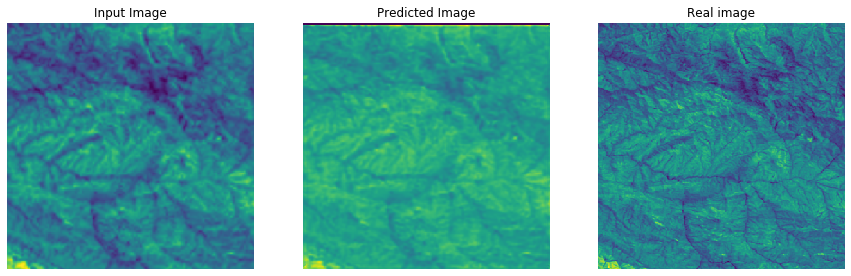

Time taken for epoch 80 is 101.55310082435608 sec

current val losses: tf.Tensor(0.031046648, shape=(), dtype=float32)
Time taken for epoch 81 is 100.3871397972107 sec

current val losses: tf.Tensor(0.030404411, shape=(), dtype=float32)
Time taken for epoch 82 is 98.6392776966095 sec

current val losses: tf.Tensor(0.030956514, shape=(), dtype=float32)
Time taken for epoch 83 is 94.56447768211365 sec

current val losses: tf.Tensor(0.028953765, shape=(), dtype=float32)
Time taken for epoch 84 is 94.62341141700745 sec

current val losses: tf.Tensor(0.029652104, shape=(), dtype=float32)
Time taken for epoch 85 is 94.02537417411804 sec

current val losses: tf.Tensor(0.028339889, shape=(), dtype=float32)
Time taken for epoch 86 is 93.70496082305908 sec

current val losses: tf.Tensor(0.029513458, shape=(), dtype=float32)
Time taken for epoch 87 is 93.66843843460083 sec

current val losses: tf.Tensor(0.028954057, shape=(), dtype=float32)
Time taken for epoch 88 is 92.84554123878479 sec

curren

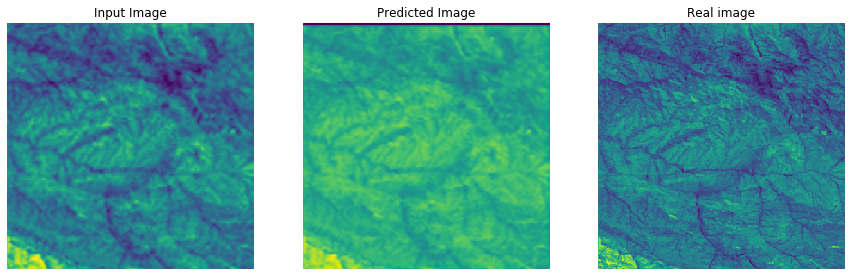

Time taken for epoch 100 is 101.81234121322632 sec

current val losses: tf.Tensor(0.02916551, shape=(), dtype=float32)
Time taken for epoch 101 is 102.1234917640686 sec

current val losses: tf.Tensor(0.02873315, shape=(), dtype=float32)
Time taken for epoch 102 is 101.27257013320923 sec

current val losses: tf.Tensor(0.0297465, shape=(), dtype=float32)
Time taken for epoch 103 is 101.09604978561401 sec

current val losses: tf.Tensor(0.028264407, shape=(), dtype=float32)
Time taken for epoch 104 is 97.31080102920532 sec

current val losses: tf.Tensor(0.03130987, shape=(), dtype=float32)
Time taken for epoch 105 is 92.98925304412842 sec

current val losses: tf.Tensor(0.02926099, shape=(), dtype=float32)
Time taken for epoch 106 is 92.96530771255493 sec

current val losses: tf.Tensor(0.0291318, shape=(), dtype=float32)
Time taken for epoch 107 is 92.64614462852478 sec

current val losses: tf.Tensor(0.031398546, shape=(), dtype=float32)
Time taken for epoch 108 is 93.0667085647583 sec

cur

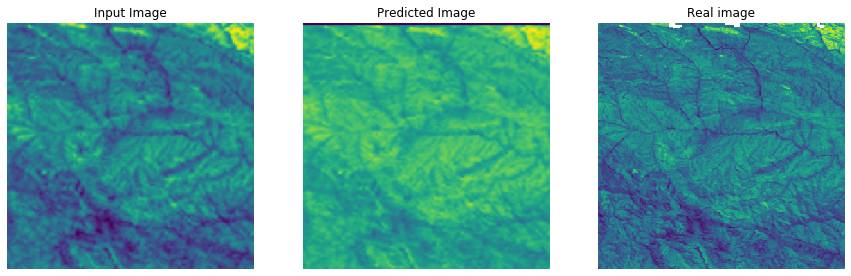

Time taken for epoch 120 is 94.69377565383911 sec

current val losses: tf.Tensor(0.02834544, shape=(), dtype=float32)
Time taken for epoch 121 is 93.29186940193176 sec

current val losses: tf.Tensor(0.029435085, shape=(), dtype=float32)
Time taken for epoch 122 is 92.84531760215759 sec

current val losses: tf.Tensor(0.02895376, shape=(), dtype=float32)
Time taken for epoch 123 is 92.96867799758911 sec

current val losses: tf.Tensor(0.029347617, shape=(), dtype=float32)
Time taken for epoch 124 is 92.99715662002563 sec

current val losses: tf.Tensor(0.028205777, shape=(), dtype=float32)
Time taken for epoch 125 is 93.05961394309998 sec

current val losses: tf.Tensor(0.02768628, shape=(), dtype=float32)
Time taken for epoch 126 is 92.3798611164093 sec

current val losses: tf.Tensor(0.028768666, shape=(), dtype=float32)
Time taken for epoch 127 is 92.5964868068695 sec

current val losses: tf.Tensor(0.02825515, shape=(), dtype=float32)
Time taken for epoch 128 is 92.76040768623352 sec

cur

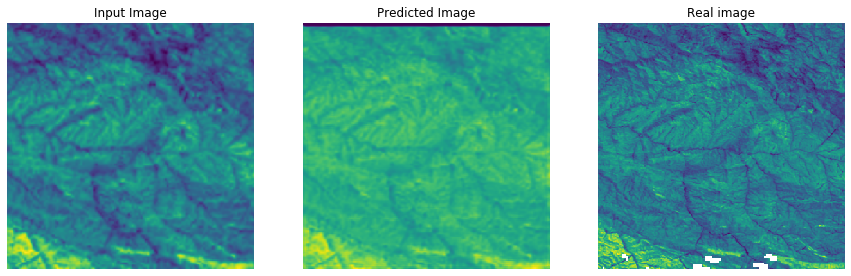

Time taken for epoch 140 is 94.37416982650757 sec

current val losses: tf.Tensor(0.030942582, shape=(), dtype=float32)
Time taken for epoch 141 is 93.06963872909546 sec

current val losses: tf.Tensor(0.03034762, shape=(), dtype=float32)
Time taken for epoch 142 is 93.79767060279846 sec

current val losses: tf.Tensor(0.027698165, shape=(), dtype=float32)
Time taken for epoch 143 is 93.56530332565308 sec

current val losses: tf.Tensor(0.027913125, shape=(), dtype=float32)
Time taken for epoch 144 is 94.1694130897522 sec

current val losses: tf.Tensor(0.028091036, shape=(), dtype=float32)
Time taken for epoch 145 is 92.9823808670044 sec

current val losses: tf.Tensor(0.029239686, shape=(), dtype=float32)
Time taken for epoch 146 is 92.87320065498352 sec

current val losses: tf.Tensor(0.02778414, shape=(), dtype=float32)
Time taken for epoch 147 is 97.59640264511108 sec

current val losses: tf.Tensor(0.02821006, shape=(), dtype=float32)
Time taken for epoch 148 is 97.11944031715393 sec

cu

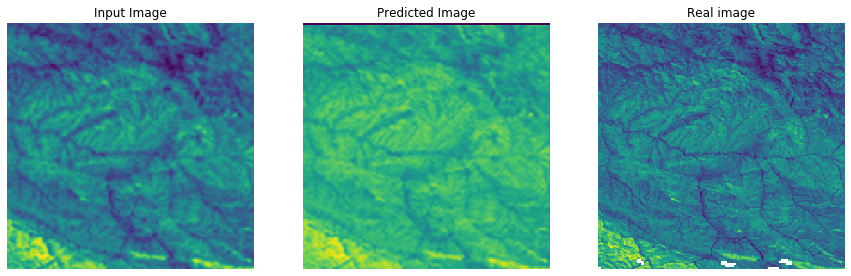

Time taken for epoch 160 is 93.59685850143433 sec

current val losses: tf.Tensor(0.027685244, shape=(), dtype=float32)
Time taken for epoch 161 is 94.55107045173645 sec

current val losses: tf.Tensor(0.027871784, shape=(), dtype=float32)
Time taken for epoch 162 is 93.67368388175964 sec

current val losses: tf.Tensor(0.027812872, shape=(), dtype=float32)
Time taken for epoch 163 is 92.87344145774841 sec

current val losses: tf.Tensor(0.028526455, shape=(), dtype=float32)
Time taken for epoch 164 is 91.9212749004364 sec

current val losses: tf.Tensor(0.027355848, shape=(), dtype=float32)
Time taken for epoch 165 is 91.8494176864624 sec

current val losses: tf.Tensor(0.027406558, shape=(), dtype=float32)
Time taken for epoch 166 is 93.27073669433594 sec

current val losses: tf.Tensor(0.027536122, shape=(), dtype=float32)
Time taken for epoch 167 is 93.28094673156738 sec

current val losses: tf.Tensor(0.03282785, shape=(), dtype=float32)
Time taken for epoch 168 is 93.47727513313293 sec



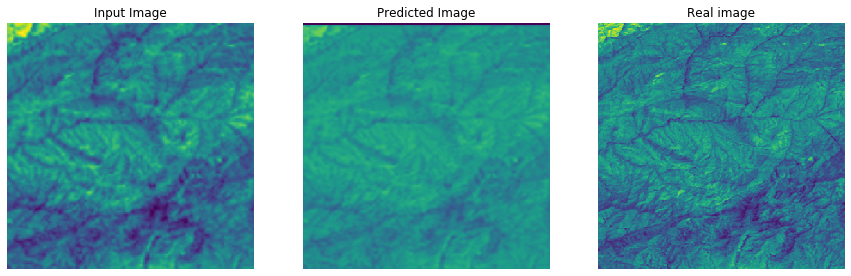

Time taken for epoch 180 is 95.3491952419281 sec

current val losses: tf.Tensor(0.027757494, shape=(), dtype=float32)
Time taken for epoch 181 is 93.14379501342773 sec

current val losses: tf.Tensor(0.02816526, shape=(), dtype=float32)
Time taken for epoch 182 is 93.65993738174438 sec

current val losses: tf.Tensor(0.028138766, shape=(), dtype=float32)
Time taken for epoch 183 is 95.3855390548706 sec

current val losses: tf.Tensor(0.028828308, shape=(), dtype=float32)
Time taken for epoch 184 is 94.50752258300781 sec

current val losses: tf.Tensor(0.027576298, shape=(), dtype=float32)
Time taken for epoch 185 is 93.54434204101562 sec

current val losses: tf.Tensor(0.029058252, shape=(), dtype=float32)
Time taken for epoch 186 is 93.4518392086029 sec

current val losses: tf.Tensor(0.029383887, shape=(), dtype=float32)
Time taken for epoch 187 is 95.91473054885864 sec

current val losses: tf.Tensor(0.028144298, shape=(), dtype=float32)
Time taken for epoch 188 is 94.62450742721558 sec

c

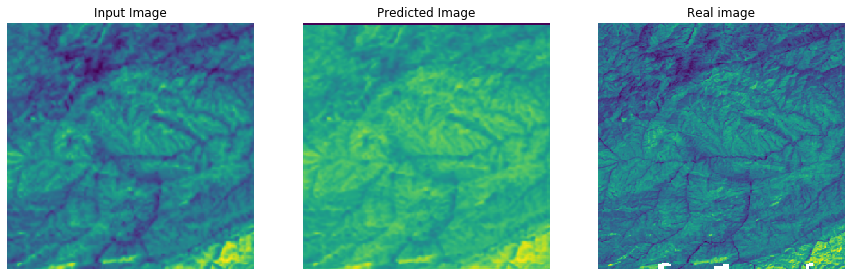

Time taken for epoch 200 is 96.62628412246704 sec

current val losses: tf.Tensor(0.027960004, shape=(), dtype=float32)


KeyboardInterrupt: 

In [21]:
train(train_dataset, dev_dataset, 301)

Time taken for epoch 1 is 105.75073313713074 sec

current val losses: tf.Tensor(0.17802887, shape=(), dtype=float32)
Time taken for epoch 2 is 99.58912777900696 sec

current val losses: tf.Tensor(0.0066627986, shape=(), dtype=float32)
Time taken for epoch 3 is 99.9516110420227 sec

current val losses: tf.Tensor(0.009992034, shape=(), dtype=float32)
Time taken for epoch 4 is 99.93175673484802 sec

current val losses: tf.Tensor(0.0027720563, shape=(), dtype=float32)
Time taken for epoch 5 is 100.05178594589233 sec

current val losses: tf.Tensor(0.0013690555, shape=(), dtype=float32)
Time taken for epoch 6 is 99.7200071811676 sec

current val losses: tf.Tensor(0.0010158183, shape=(), dtype=float32)
Time taken for epoch 7 is 99.48132538795471 sec

current val losses: tf.Tensor(0.0012193725, shape=(), dtype=float32)
Time taken for epoch 8 is 100.06499290466309 sec

current val losses: tf.Tensor(0.00094534387, shape=(), dtype=float32)
Time taken for epoch 9 is 99.97353076934814 sec

current 

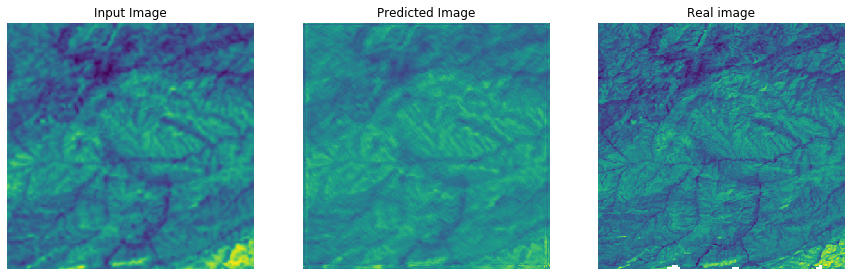

Time taken for epoch 20 is 100.45849871635437 sec

current val losses: tf.Tensor(0.00079627207, shape=(), dtype=float32)
Time taken for epoch 21 is 99.80612468719482 sec

current val losses: tf.Tensor(0.00062891777, shape=(), dtype=float32)
Time taken for epoch 22 is 99.42193555831909 sec

current val losses: tf.Tensor(0.0006254106, shape=(), dtype=float32)
Time taken for epoch 23 is 99.4294183254242 sec

current val losses: tf.Tensor(0.00058326166, shape=(), dtype=float32)
Time taken for epoch 24 is 99.80414628982544 sec

current val losses: tf.Tensor(0.007990646, shape=(), dtype=float32)
Time taken for epoch 25 is 99.48161244392395 sec

current val losses: tf.Tensor(0.0010242561, shape=(), dtype=float32)
Time taken for epoch 26 is 99.85544466972351 sec

current val losses: tf.Tensor(0.0007159916, shape=(), dtype=float32)
Time taken for epoch 27 is 99.68735814094543 sec

current val losses: tf.Tensor(0.0007332125, shape=(), dtype=float32)
Time taken for epoch 28 is 99.85800862312317 s

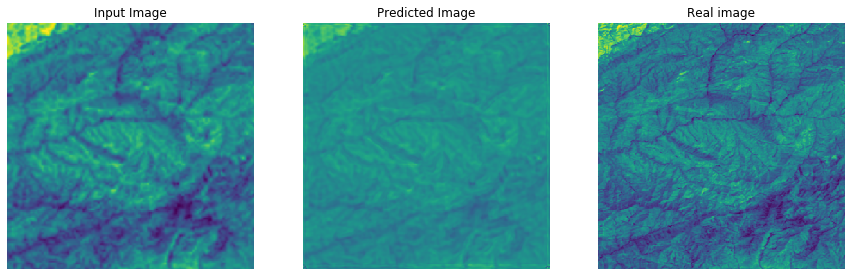

Time taken for epoch 40 is 100.4743139743805 sec

current val losses: tf.Tensor(0.0004354906, shape=(), dtype=float32)
Time taken for epoch 41 is 99.6782636642456 sec

current val losses: tf.Tensor(0.0004684021, shape=(), dtype=float32)
Time taken for epoch 42 is 100.28555536270142 sec

current val losses: tf.Tensor(0.00046025903, shape=(), dtype=float32)
Time taken for epoch 43 is 99.56523585319519 sec

current val losses: tf.Tensor(0.0004446155, shape=(), dtype=float32)
Time taken for epoch 44 is 99.47339415550232 sec

current val losses: tf.Tensor(0.00046381864, shape=(), dtype=float32)
Time taken for epoch 45 is 100.937415599823 sec

current val losses: tf.Tensor(0.00039965217, shape=(), dtype=float32)
Time taken for epoch 46 is 99.79807305335999 sec

current val losses: tf.Tensor(0.00045232408, shape=(), dtype=float32)
Time taken for epoch 47 is 99.70141339302063 sec

current val losses: tf.Tensor(0.00055891025, shape=(), dtype=float32)
Time taken for epoch 48 is 100.012455701828 

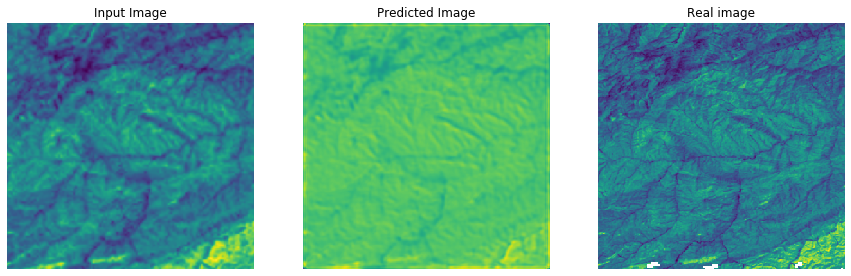

Time taken for epoch 60 is 100.67239260673523 sec

current val losses: tf.Tensor(0.00059468305, shape=(), dtype=float32)
Time taken for epoch 61 is 99.50128412246704 sec

current val losses: tf.Tensor(0.0005420553, shape=(), dtype=float32)
Time taken for epoch 62 is 99.4351954460144 sec

current val losses: tf.Tensor(0.0004988709, shape=(), dtype=float32)
Time taken for epoch 63 is 99.83555603027344 sec

current val losses: tf.Tensor(0.0004715706, shape=(), dtype=float32)
Time taken for epoch 64 is 99.9392774105072 sec

current val losses: tf.Tensor(0.00047430224, shape=(), dtype=float32)
Time taken for epoch 65 is 99.60084438323975 sec

current val losses: tf.Tensor(0.00045861554, shape=(), dtype=float32)
Time taken for epoch 66 is 100.04865837097168 sec

current val losses: tf.Tensor(0.00046958256, shape=(), dtype=float32)
Time taken for epoch 67 is 99.91647410392761 sec

current val losses: tf.Tensor(0.000458841, shape=(), dtype=float32)
Time taken for epoch 68 is 99.50077605247498 

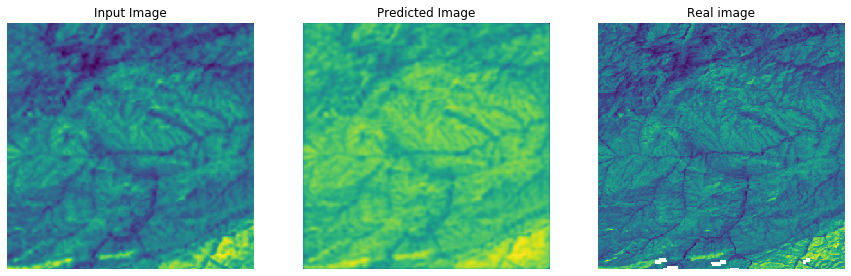

Time taken for epoch 80 is 100.70346021652222 sec

current val losses: tf.Tensor(0.00043615192, shape=(), dtype=float32)
Time taken for epoch 81 is 99.82825040817261 sec

current val losses: tf.Tensor(0.0004813686, shape=(), dtype=float32)
Time taken for epoch 82 is 99.767080783844 sec

current val losses: tf.Tensor(0.0004613293, shape=(), dtype=float32)
Time taken for epoch 83 is 99.62136149406433 sec

current val losses: tf.Tensor(0.00041993603, shape=(), dtype=float32)
Time taken for epoch 84 is 99.81142544746399 sec

current val losses: tf.Tensor(0.00039869623, shape=(), dtype=float32)
Time taken for epoch 85 is 99.63948345184326 sec

current val losses: tf.Tensor(0.0003946557, shape=(), dtype=float32)
Time taken for epoch 86 is 100.70002007484436 sec

current val losses: tf.Tensor(0.00043714006, shape=(), dtype=float32)
Time taken for epoch 87 is 100.48237776756287 sec

current val losses: tf.Tensor(0.00046310844, shape=(), dtype=float32)
Time taken for epoch 88 is 99.863000869750

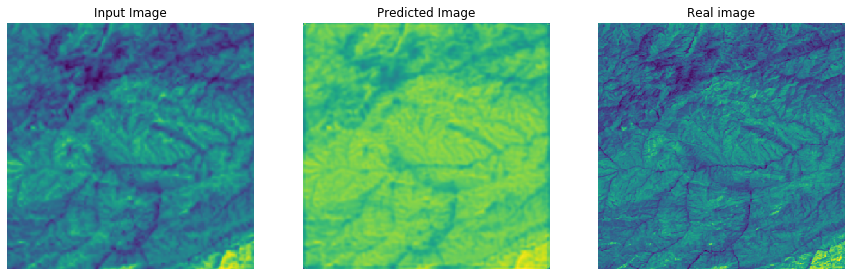

Time taken for epoch 100 is 100.75368118286133 sec

current val losses: tf.Tensor(0.00041345353, shape=(), dtype=float32)
Time taken for epoch 101 is 99.75533938407898 sec

current val losses: tf.Tensor(0.0005941034, shape=(), dtype=float32)
Time taken for epoch 102 is 99.60596656799316 sec

current val losses: tf.Tensor(0.00051101187, shape=(), dtype=float32)
Time taken for epoch 103 is 99.52421593666077 sec

current val losses: tf.Tensor(0.0007211471, shape=(), dtype=float32)
Time taken for epoch 104 is 100.082603931427 sec

current val losses: tf.Tensor(0.00062209275, shape=(), dtype=float32)
Time taken for epoch 105 is 99.79998874664307 sec

current val losses: tf.Tensor(0.0004482001, shape=(), dtype=float32)
Time taken for epoch 106 is 99.60849285125732 sec

current val losses: tf.Tensor(0.0017683823, shape=(), dtype=float32)
Time taken for epoch 107 is 99.38930773735046 sec

current val losses: tf.Tensor(0.005092224, shape=(), dtype=float32)
Time taken for epoch 108 is 99.4800033

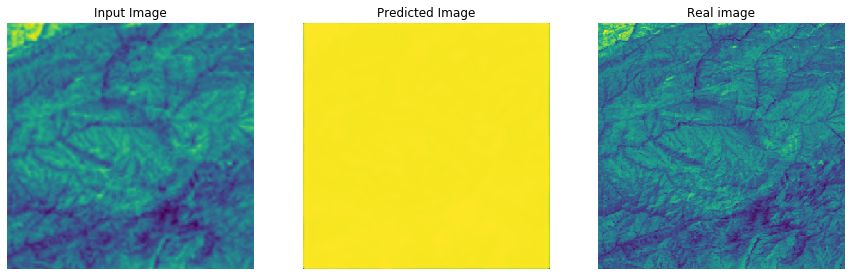

Time taken for epoch 120 is 97.36978268623352 sec

current val losses: tf.Tensor(0.0050411224, shape=(), dtype=float32)
Time taken for epoch 121 is 96.65028238296509 sec

current val losses: tf.Tensor(0.005068285, shape=(), dtype=float32)
Time taken for epoch 122 is 97.07771039009094 sec

current val losses: tf.Tensor(0.00506674, shape=(), dtype=float32)
Time taken for epoch 123 is 97.01694631576538 sec

current val losses: tf.Tensor(0.005091268, shape=(), dtype=float32)
Time taken for epoch 124 is 97.04995703697205 sec

current val losses: tf.Tensor(0.0050550187, shape=(), dtype=float32)
Time taken for epoch 125 is 97.0121591091156 sec

current val losses: tf.Tensor(0.0052112676, shape=(), dtype=float32)
Time taken for epoch 126 is 96.6414270401001 sec

current val losses: tf.Tensor(0.0051499913, shape=(), dtype=float32)
Time taken for epoch 127 is 97.117600440979 sec

current val losses: tf.Tensor(0.0051432694, shape=(), dtype=float32)
Time taken for epoch 128 is 96.77979946136475 se

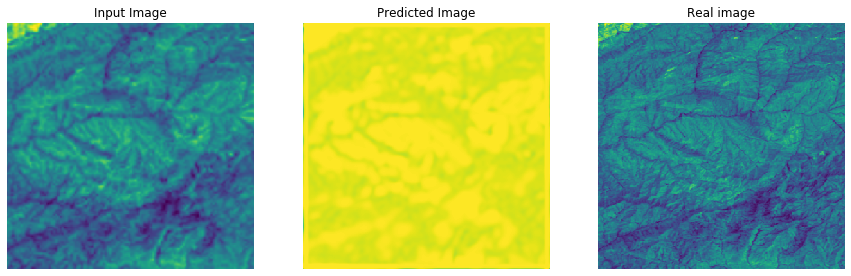

Time taken for epoch 140 is 97.76455998420715 sec

current val losses: tf.Tensor(0.005176003, shape=(), dtype=float32)
Time taken for epoch 141 is 97.003182888031 sec

current val losses: tf.Tensor(0.0051611816, shape=(), dtype=float32)
Time taken for epoch 142 is 96.74155592918396 sec

current val losses: tf.Tensor(0.00508901, shape=(), dtype=float32)
Time taken for epoch 143 is 97.14422655105591 sec

current val losses: tf.Tensor(0.0050675906, shape=(), dtype=float32)
Time taken for epoch 144 is 96.68722796440125 sec

current val losses: tf.Tensor(0.0050419387, shape=(), dtype=float32)
Time taken for epoch 145 is 97.41583847999573 sec

current val losses: tf.Tensor(0.0050496645, shape=(), dtype=float32)
Time taken for epoch 146 is 96.77832174301147 sec

current val losses: tf.Tensor(0.005059772, shape=(), dtype=float32)
Time taken for epoch 147 is 98.06146097183228 sec

current val losses: tf.Tensor(0.0050412416, shape=(), dtype=float32)
Time taken for epoch 148 is 96.6290557384491 s

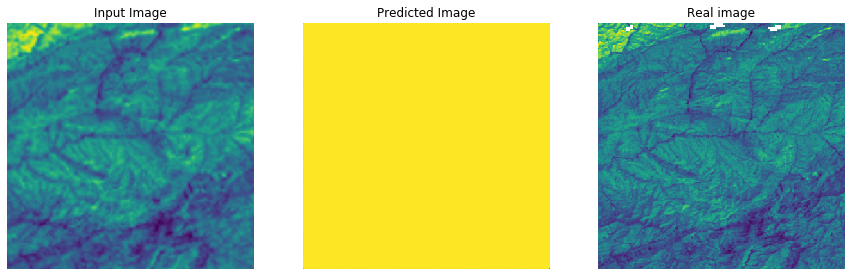

Time taken for epoch 160 is 98.51150298118591 sec

current val losses: tf.Tensor(0.0050613056, shape=(), dtype=float32)
Time taken for epoch 161 is 96.67883729934692 sec

current val losses: tf.Tensor(0.0050154147, shape=(), dtype=float32)
Time taken for epoch 162 is 97.1142258644104 sec

current val losses: tf.Tensor(0.00504781, shape=(), dtype=float32)
Time taken for epoch 163 is 96.73214411735535 sec

current val losses: tf.Tensor(0.005030691, shape=(), dtype=float32)
Time taken for epoch 164 is 97.37373280525208 sec

current val losses: tf.Tensor(0.005091616, shape=(), dtype=float32)
Time taken for epoch 165 is 96.81107139587402 sec

current val losses: tf.Tensor(0.0050997618, shape=(), dtype=float32)
Time taken for epoch 166 is 96.75670337677002 sec

current val losses: tf.Tensor(0.005088502, shape=(), dtype=float32)
Time taken for epoch 167 is 96.67035984992981 sec

current val losses: tf.Tensor(0.00507378, shape=(), dtype=float32)
Time taken for epoch 168 is 96.72323179244995 se

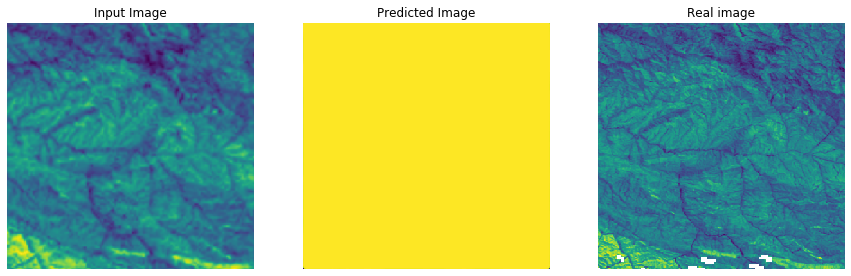

Time taken for epoch 180 is 97.68088102340698 sec

current val losses: tf.Tensor(0.0050815954, shape=(), dtype=float32)
Time taken for epoch 181 is 96.67797183990479 sec

current val losses: tf.Tensor(0.005048965, shape=(), dtype=float32)
Time taken for epoch 182 is 97.07969212532043 sec

current val losses: tf.Tensor(0.005063949, shape=(), dtype=float32)
Time taken for epoch 183 is 97.01431345939636 sec

current val losses: tf.Tensor(0.0050601903, shape=(), dtype=float32)
Time taken for epoch 184 is 97.1658763885498 sec

current val losses: tf.Tensor(0.005073731, shape=(), dtype=float32)
Time taken for epoch 185 is 96.8097460269928 sec

current val losses: tf.Tensor(0.0050579514, shape=(), dtype=float32)
Time taken for epoch 186 is 96.90098977088928 sec

current val losses: tf.Tensor(0.00503668, shape=(), dtype=float32)
Time taken for epoch 187 is 97.05325198173523 sec

current val losses: tf.Tensor(0.005088087, shape=(), dtype=float32)
Time taken for epoch 188 is 96.7532639503479 sec

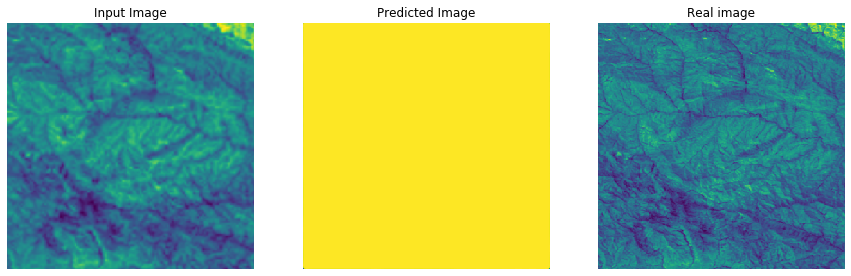

Time taken for epoch 200 is 98.0599091053009 sec

current val losses: tf.Tensor(0.0050736666, shape=(), dtype=float32)
Time taken for epoch 201 is 96.75083374977112 sec

current val losses: tf.Tensor(0.0050984975, shape=(), dtype=float32)
Time taken for epoch 202 is 96.61053276062012 sec

current val losses: tf.Tensor(0.0050482703, shape=(), dtype=float32)
Time taken for epoch 203 is 97.13161039352417 sec

current val losses: tf.Tensor(0.005017085, shape=(), dtype=float32)
Time taken for epoch 204 is 96.93590641021729 sec

current val losses: tf.Tensor(0.005072941, shape=(), dtype=float32)
Time taken for epoch 205 is 97.02957057952881 sec

current val losses: tf.Tensor(0.0050208056, shape=(), dtype=float32)
Time taken for epoch 206 is 97.0145206451416 sec

current val losses: tf.Tensor(0.005056673, shape=(), dtype=float32)
Time taken for epoch 207 is 96.88847613334656 sec

current val losses: tf.Tensor(0.0050746817, shape=(), dtype=float32)
Time taken for epoch 208 is 96.95135498046875

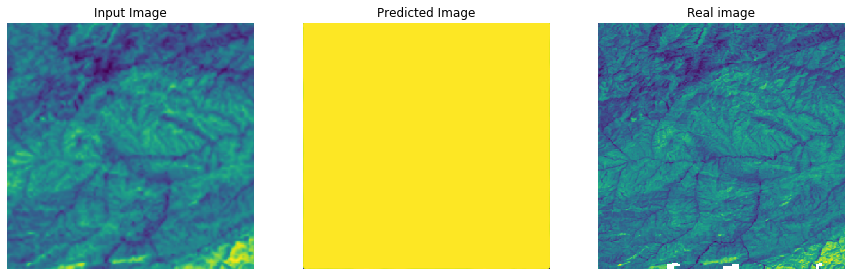

Time taken for epoch 220 is 97.74993848800659 sec

current val losses: tf.Tensor(0.005045173, shape=(), dtype=float32)
Time taken for epoch 221 is 96.65596055984497 sec

current val losses: tf.Tensor(0.005055423, shape=(), dtype=float32)
Time taken for epoch 222 is 97.04871392250061 sec

current val losses: tf.Tensor(0.0050944705, shape=(), dtype=float32)
Time taken for epoch 223 is 97.0416169166565 sec

current val losses: tf.Tensor(0.005089621, shape=(), dtype=float32)
Time taken for epoch 224 is 96.79921841621399 sec

current val losses: tf.Tensor(0.005069084, shape=(), dtype=float32)
Time taken for epoch 225 is 96.9023928642273 sec

current val losses: tf.Tensor(0.005103618, shape=(), dtype=float32)
Time taken for epoch 226 is 97.13077783584595 sec

current val losses: tf.Tensor(0.0051023285, shape=(), dtype=float32)
Time taken for epoch 227 is 96.64885592460632 sec

current val losses: tf.Tensor(0.005061627, shape=(), dtype=float32)
Time taken for epoch 228 is 96.80955171585083 se

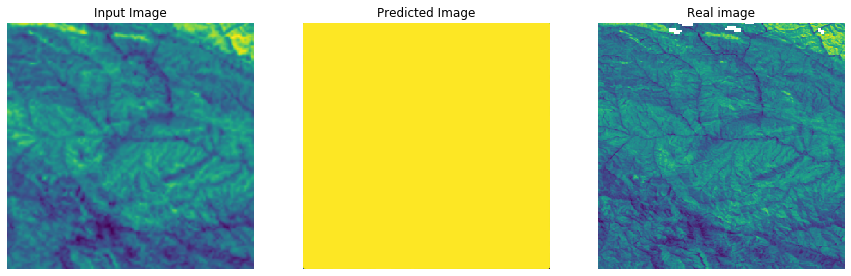

Time taken for epoch 240 is 97.72963643074036 sec

current val losses: tf.Tensor(0.005098329, shape=(), dtype=float32)
Time taken for epoch 241 is 96.77882957458496 sec

current val losses: tf.Tensor(0.0050364095, shape=(), dtype=float32)
Time taken for epoch 242 is 96.96783828735352 sec

current val losses: tf.Tensor(0.0050420295, shape=(), dtype=float32)
Time taken for epoch 243 is 96.61801505088806 sec

current val losses: tf.Tensor(0.005035511, shape=(), dtype=float32)
Time taken for epoch 244 is 96.93120050430298 sec

current val losses: tf.Tensor(0.0050495286, shape=(), dtype=float32)
Time taken for epoch 245 is 97.33825182914734 sec

current val losses: tf.Tensor(0.0050341794, shape=(), dtype=float32)
Time taken for epoch 246 is 96.99760484695435 sec

current val losses: tf.Tensor(0.0050361212, shape=(), dtype=float32)
Time taken for epoch 247 is 96.62602424621582 sec

current val losses: tf.Tensor(0.005039409, shape=(), dtype=float32)
Time taken for epoch 248 is 96.709593296051

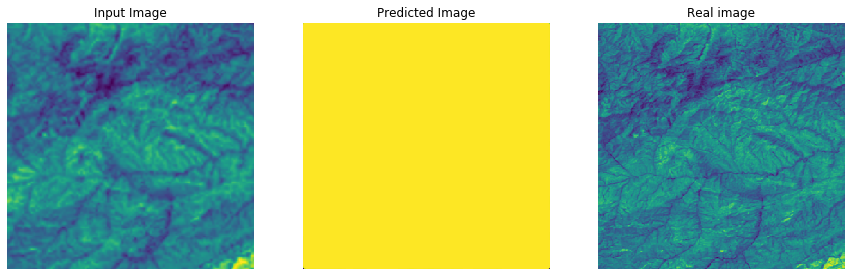

Time taken for epoch 260 is 97.65208888053894 sec

current val losses: tf.Tensor(0.005043788, shape=(), dtype=float32)
Time taken for epoch 261 is 96.95410084724426 sec

current val losses: tf.Tensor(0.0050600274, shape=(), dtype=float32)
Time taken for epoch 262 is 97.02950930595398 sec

current val losses: tf.Tensor(0.005031196, shape=(), dtype=float32)
Time taken for epoch 263 is 97.01162552833557 sec

current val losses: tf.Tensor(0.005076553, shape=(), dtype=float32)
Time taken for epoch 264 is 96.91346597671509 sec

current val losses: tf.Tensor(0.005060031, shape=(), dtype=float32)
Time taken for epoch 265 is 97.40810680389404 sec

current val losses: tf.Tensor(0.0050614816, shape=(), dtype=float32)
Time taken for epoch 266 is 96.91147756576538 sec

current val losses: tf.Tensor(0.005035787, shape=(), dtype=float32)
Time taken for epoch 267 is 96.62922978401184 sec

current val losses: tf.Tensor(0.0050485833, shape=(), dtype=float32)
Time taken for epoch 268 is 96.65766191482544

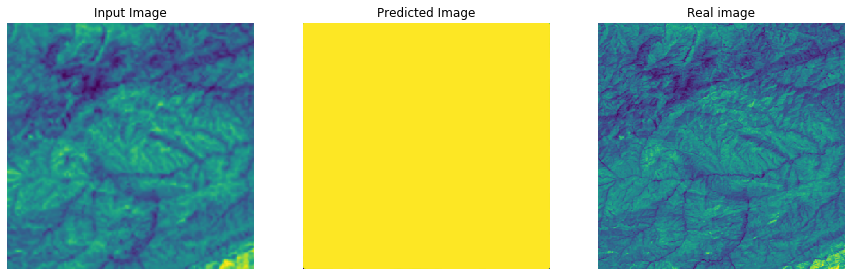

Time taken for epoch 280 is 97.45565462112427 sec

current val losses: tf.Tensor(0.0050456533, shape=(), dtype=float32)
Time taken for epoch 281 is 97.40042638778687 sec

current val losses: tf.Tensor(0.00508031, shape=(), dtype=float32)
Time taken for epoch 282 is 96.6948869228363 sec

current val losses: tf.Tensor(0.0050953296, shape=(), dtype=float32)
Time taken for epoch 283 is 97.30669808387756 sec

current val losses: tf.Tensor(0.0050660167, shape=(), dtype=float32)
Time taken for epoch 284 is 96.91096520423889 sec

current val losses: tf.Tensor(0.0050676325, shape=(), dtype=float32)
Time taken for epoch 285 is 97.16956496238708 sec

current val losses: tf.Tensor(0.0050260443, shape=(), dtype=float32)
Time taken for epoch 286 is 96.88221001625061 sec

current val losses: tf.Tensor(0.005093966, shape=(), dtype=float32)
Time taken for epoch 287 is 97.06615352630615 sec

current val losses: tf.Tensor(0.0050689285, shape=(), dtype=float32)
Time taken for epoch 288 is 96.9311163425445

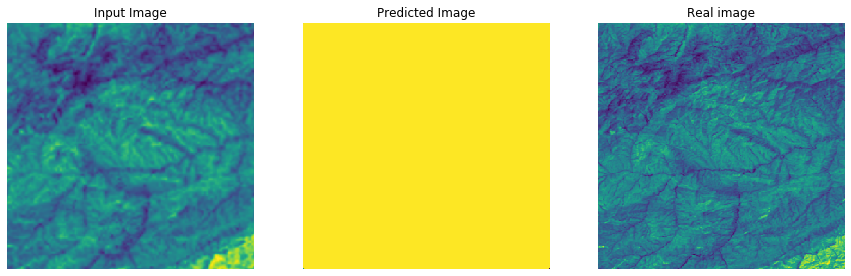

Time taken for epoch 300 is 97.8562867641449 sec

current val losses: tf.Tensor(0.0050585717, shape=(), dtype=float32)
Time taken for epoch 301 is 96.63060903549194 sec

current val losses: tf.Tensor(0.0050742063, shape=(), dtype=float32)
Time taken for epoch 302 is 97.11733484268188 sec

current val losses: tf.Tensor(0.005030074, shape=(), dtype=float32)
Time taken for epoch 303 is 97.24596071243286 sec

current val losses: tf.Tensor(0.005050025, shape=(), dtype=float32)
Time taken for epoch 304 is 96.61525368690491 sec

current val losses: tf.Tensor(0.0050656362, shape=(), dtype=float32)
Time taken for epoch 305 is 96.94105434417725 sec

current val losses: tf.Tensor(0.0051016114, shape=(), dtype=float32)
Time taken for epoch 306 is 96.86531281471252 sec

current val losses: tf.Tensor(0.0051092533, shape=(), dtype=float32)
Time taken for epoch 307 is 96.95301818847656 sec

current val losses: tf.Tensor(0.0050472077, shape=(), dtype=float32)
Time taken for epoch 308 is 96.726532936096

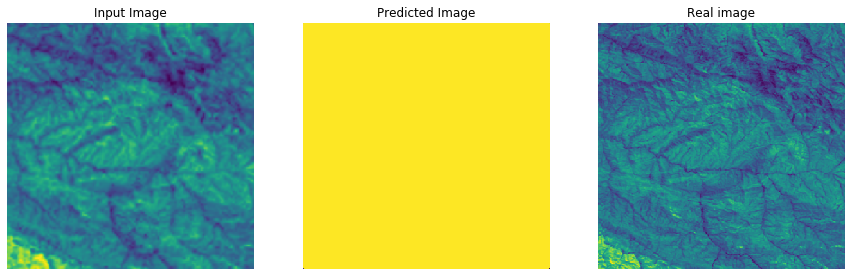

Time taken for epoch 320 is 97.9551796913147 sec

current val losses: tf.Tensor(0.005038596, shape=(), dtype=float32)
Time taken for epoch 321 is 96.95273780822754 sec

current val losses: tf.Tensor(0.005017466, shape=(), dtype=float32)
Time taken for epoch 322 is 96.99974060058594 sec

current val losses: tf.Tensor(0.0050690733, shape=(), dtype=float32)
Time taken for epoch 323 is 97.01688647270203 sec

current val losses: tf.Tensor(0.005069762, shape=(), dtype=float32)
Time taken for epoch 324 is 96.96663498878479 sec

current val losses: tf.Tensor(0.0050586807, shape=(), dtype=float32)
Time taken for epoch 325 is 97.38114476203918 sec

current val losses: tf.Tensor(0.0050388547, shape=(), dtype=float32)
Time taken for epoch 326 is 96.67356777191162 sec

current val losses: tf.Tensor(0.005048898, shape=(), dtype=float32)
Time taken for epoch 327 is 96.88700866699219 sec

current val losses: tf.Tensor(0.00506422, shape=(), dtype=float32)
Time taken for epoch 328 is 96.60793876647949 s

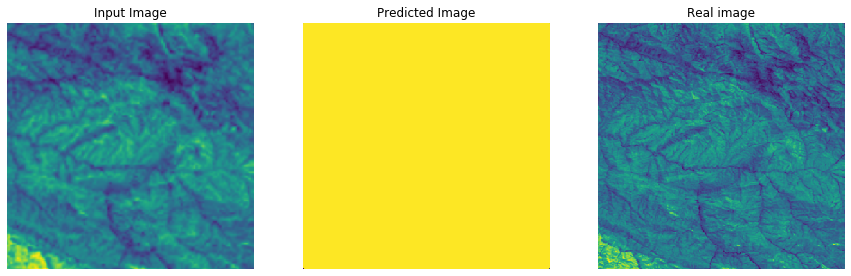

Time taken for epoch 340 is 98.71199440956116 sec

current val losses: tf.Tensor(0.005068056, shape=(), dtype=float32)
Time taken for epoch 341 is 96.95535492897034 sec

current val losses: tf.Tensor(0.0050313855, shape=(), dtype=float32)
Time taken for epoch 342 is 97.06686902046204 sec

current val losses: tf.Tensor(0.005076988, shape=(), dtype=float32)
Time taken for epoch 343 is 96.63066720962524 sec

current val losses: tf.Tensor(0.0051191053, shape=(), dtype=float32)
Time taken for epoch 344 is 96.61108922958374 sec

current val losses: tf.Tensor(0.005083652, shape=(), dtype=float32)
Time taken for epoch 345 is 97.3134822845459 sec

current val losses: tf.Tensor(0.005074943, shape=(), dtype=float32)
Time taken for epoch 346 is 96.87514448165894 sec

current val losses: tf.Tensor(0.0050540566, shape=(), dtype=float32)
Time taken for epoch 347 is 96.82976961135864 sec

current val losses: tf.Tensor(0.0051118475, shape=(), dtype=float32)
Time taken for epoch 348 is 97.04967308044434

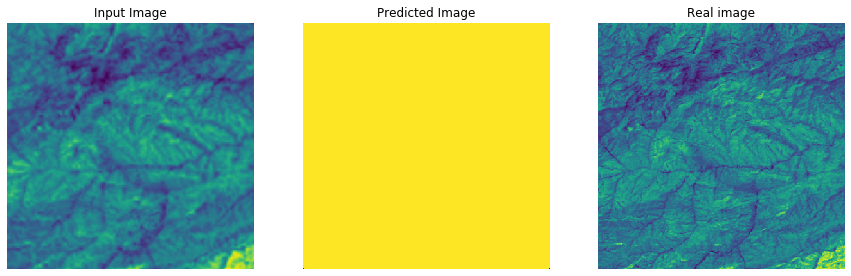

Time taken for epoch 360 is 100.36015939712524 sec

current val losses: tf.Tensor(0.0050632004, shape=(), dtype=float32)


KeyboardInterrupt: 

In [85]:
train(train_dataset, dev_dataset, EPOCHS)

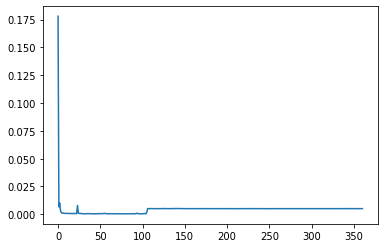

In [88]:
plt.plot(losses_record)